## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics
from mlutils.features import *
from mlutils.models.regression import *
from mlutils.models.trees import *
from mlutils.plot import *
import seaborn as sns
sns.set()

/home/quick/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
set_plot_sizes(12, 14, 16)

## Load data from previous workbook

In [4]:
PATH = "data/bulldozers/"

import feather
df_raw = feather.read_dataframe('tmp/bulldozers-raw')

df_trn, y_trn, nas = process_dataframe(df_raw, 'SalePrice')

In [5]:
n_valid = 12000
n_train = len(df_trn)-n_valid

X_train, X_val = split_vals(df_trn, n_train)
y_train, y_val = split_vals(y_trn, n_train)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((389125, 66), (12000, 66), (389125,), (12000,))

In [6]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1248307200
5,1139255,10.184900,1001274,4605,121,3.0,2004,508.0,Low,310G,...,18,3,353,False,False,False,False,False,False,1229558400
6,1139256,9.952278,772701,1937,121,3.0,1993,11540.0,High,790ELC,...,26,3,239,False,False,False,False,False,False,1093478400
7,1139261,10.203592,902002,3539,121,3.0,2001,4883.0,High,416D,...,17,3,321,False,False,False,False,False,False,1132185600
8,1139272,9.975808,1036251,36003,121,3.0,2008,302.0,Low,430HAG,...,27,3,239,False,False,False,False,False,False,1251331200
9,1139275,11.082143,1016474,3883,121,3.0,1000,20700.0,Medium,988B,...,9,3,221,False,False,False,False,False,False,1186617600


## Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [7]:
set_rf_samples(50000)

In [8]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
train_regressor(m, X_train, y_train)
m_preds = predict_and_evaluate_regressor(m, X_val, y_val)

  R2 (Training): 0.9114362300975053
RMSE (Training): 0.04237612771563255
      OOB Score: 0.8943533911246724
             R2: 0.88874
           RMSE: 0.24960


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent.

In [9]:
%time preds = np.stack([t.predict(X_val) for t in m.estimators_])
# example prediction mean and std
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 955 ms, sys: 40 ms, total: 995 ms
Wall time: 994 ms


(9.373449406275078, 0.3904263775306407)

In [10]:
# same thing as before, but running in parallel
def get_preds(t): return t.predict(X_val)
preds = np.stack(parallel_trees(m, get_preds))
preds[0]

array([ 9.70123389,  9.44766501,  9.00235298, ..., 10.58482498,
        9.20068606,  9.20068606])

We can see that different trees are giving different estimates to this auction. In order to see how prediction confidence varies, we can add this into our dataset.

In [11]:
# let's get our validation data from the original dataset
raw_train, raw_valid = split_vals(df_raw, n_train)

We can now look at predictions confidence in specific groups. Let's look at a feature called Enclosure, starting by plotting a simple histogram

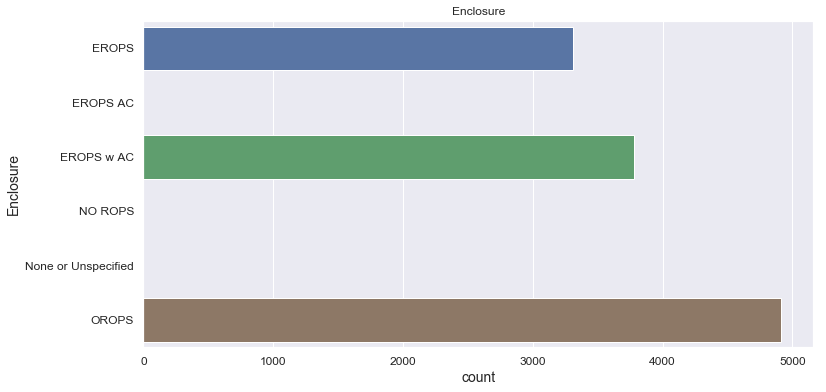

             Enclosure  SalePrice       pred  pred_std
0                EROPS   9.849178   9.841446  0.276273
1             EROPS AC        NaN        NaN       NaN
2           EROPS w AC  10.623971  10.572645  0.268527
3              NO ROPS        NaN        NaN       NaN
4  None or Unspecified        NaN        NaN       NaN
5                OROPS   9.682064   9.680686  0.226977


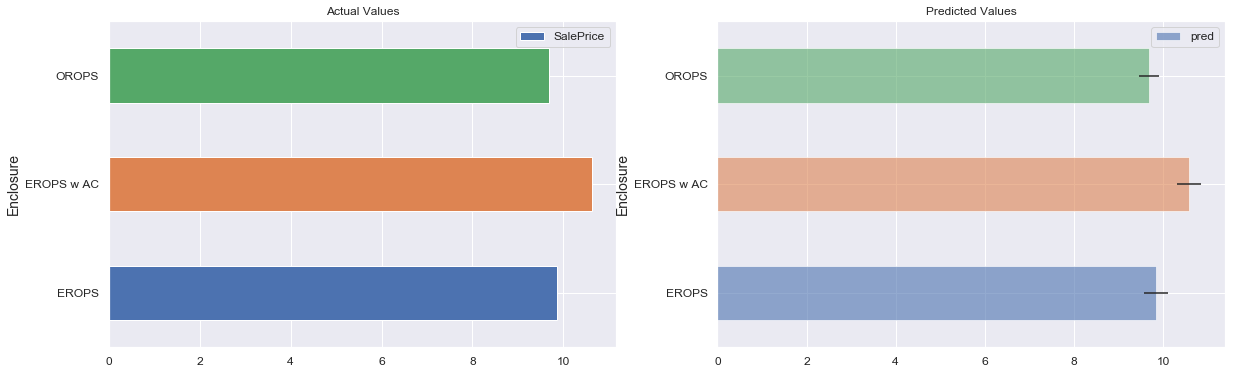

Weighted Standard Deviation
    Enclosure  weighed_std
0       EROPS     0.028072
2  EROPS w AC     0.025398
5       OROPS     0.023446


In [12]:
analyze_predictions_in_group(raw_valid, 'Enclosure', 'SalePrice', preds)

Standard deviation is fairly constant across all the Enclosure values. Let's see another example.

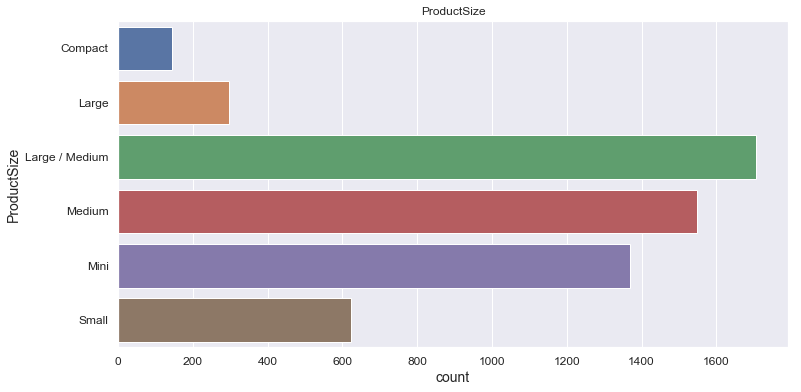

      ProductSize  SalePrice       pred  pred_std
0         Compact   9.735093   9.838298  0.345654
1           Large  10.470589  10.392118  0.373831
2  Large / Medium  10.691871  10.652338  0.298491
3          Medium  10.681511  10.618396  0.293187
4            Mini   9.535147   9.562230  0.253737
5           Small  10.324448  10.331786  0.314086


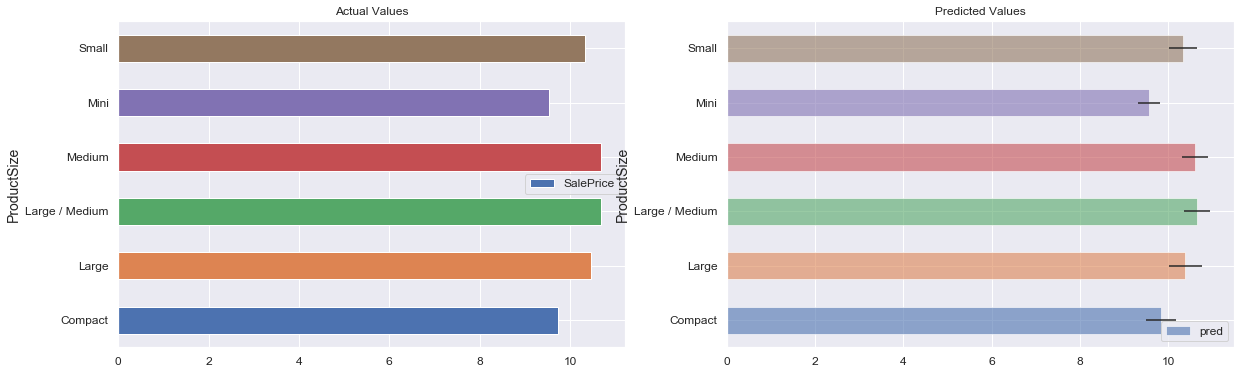

Weighted Standard Deviation
      ProductSize  weighed_std
1           Large     0.035973
0         Compact     0.035134
5           Small     0.030400
2  Large / Medium     0.028021
3          Medium     0.027611
4            Mini     0.026535


In [13]:
analyze_predictions_in_group(raw_valid, 'ProductSize','SalePrice', preds)

In this case we notice a higher deviation in Compat, Large and Small. When we compare that to the histogram, we see these are the less representative values in the dataset

## Feature Importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [19]:
# to make analysis faster
set_rf_samples(50000)

fi = rf_feat_importance(m, X_train)
fi[:10]

,cols,imp
5,YearMade,0.170777
37,Coupler_System,0.106546
13,ProductSize,0.099386
14,fiProductClassDesc,0.075836
2,ModelID,0.051163
63,saleElapsed,0.049745
10,fiSecondaryDesc,0.047889
39,Hydraulics_Flow,0.047851
38,Grouser_Tracks,0.041389
19,Enclosure,0.035696


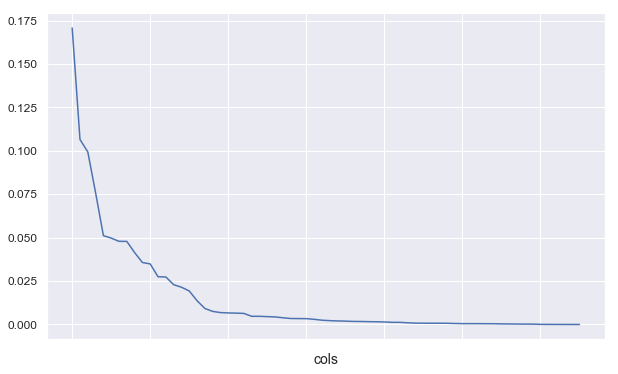

In [20]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

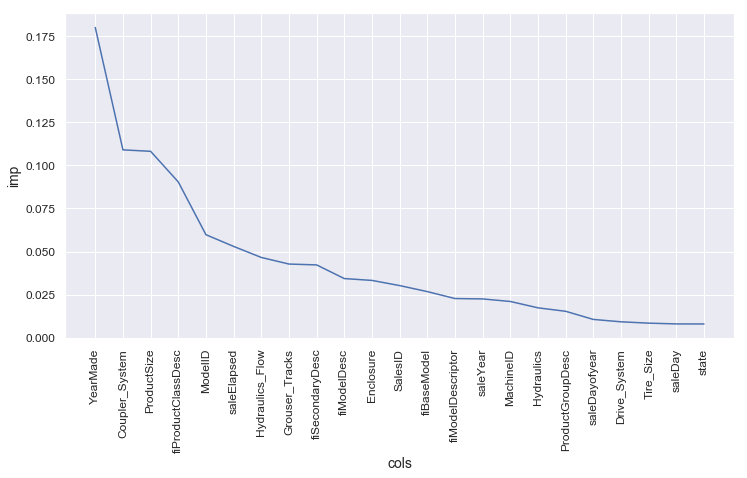

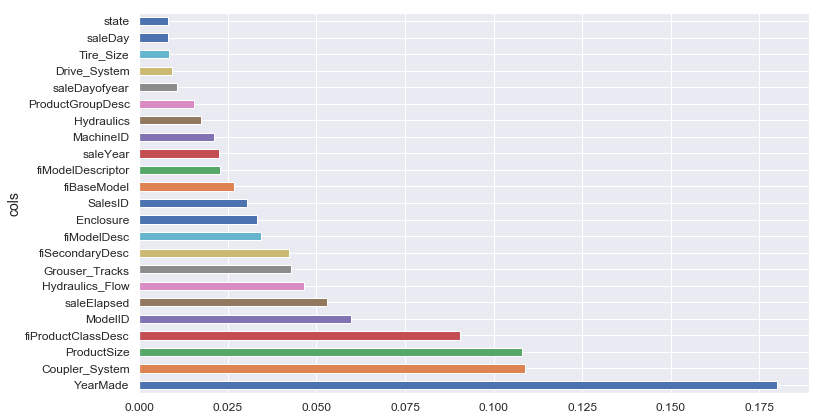

In [30]:
# a better plot is on the plot_feat_importance method
plot_feat_importance(fi,top=30)

In [31]:
# let's remove the least important features
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

23

In [32]:
# columns being kept
to_keep.values

array(['YearMade', 'Coupler_System', 'ProductSize', 'fiProductClassDesc',
       'ModelID', 'saleElapsed', 'Hydraulics_Flow', 'Grouser_Tracks',
       'fiSecondaryDesc', 'fiModelDesc', 'Enclosure', 'SalesID',
       'fiBaseModel', 'fiModelDescriptor', 'saleYear', 'MachineID',
       'Hydraulics', 'ProductGroupDesc', 'saleDayofyear', 'Drive_System',
       'Tire_Size', 'saleDay', 'state'], dtype=object)

In [33]:
# list of columns being removed
np.setdiff1d(df_trn.columns.values,to_keep.values)

array(['Backhoe_Mounting', 'Blade_Extension', 'Blade_Type', 'Blade_Width',
       'Coupler', 'Differential_Type', 'Enclosure_Type',
       'Engine_Horsepower', 'Forks', 'Grouser_Type',
       'MachineHoursCurrentMeter', 'MachineHoursCurrentMeter_na',
       'Pad_Type', 'Pattern_Changer', 'ProductGroup', 'Pushblock',
       'Ride_Control', 'Ripper', 'Scarifier', 'Steering_Controls',
       'Stick', 'Stick_Length', 'Thumb', 'Tip_Control', 'Track_Type',
       'Transmission', 'Travel_Controls', 'Turbocharged',
       'Undercarriage_Pad_Width', 'UsageBand', 'auctioneerID',
       'auctioneerID_na', 'datasource', 'fiModelSeries', 'saleDayofweek',
       'saleIs_month_end', 'saleIs_month_start', 'saleIs_quarter_end',
       'saleIs_quarter_start', 'saleIs_year_end', 'saleIs_year_start',
       'saleMonth', 'saleWeek'], dtype=object)

In [34]:
# remove columns and create new train and validation sets
df_keep = df_trn[to_keep].copy()
X_train, X_val = split_vals(df_keep, n_train)

In [35]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
train_regressor(m, X_train, y_train)
m_preds, r2, rmse = predict_and_evaluate_regressor(m, X_val, y_val)

  R2 (Training): 0.9105988505443179
RMSE (Training): 0.04277679836155694
      OOB Score: 0.8942864928879559
             R2: 0.89286
           RMSE: 0.24493


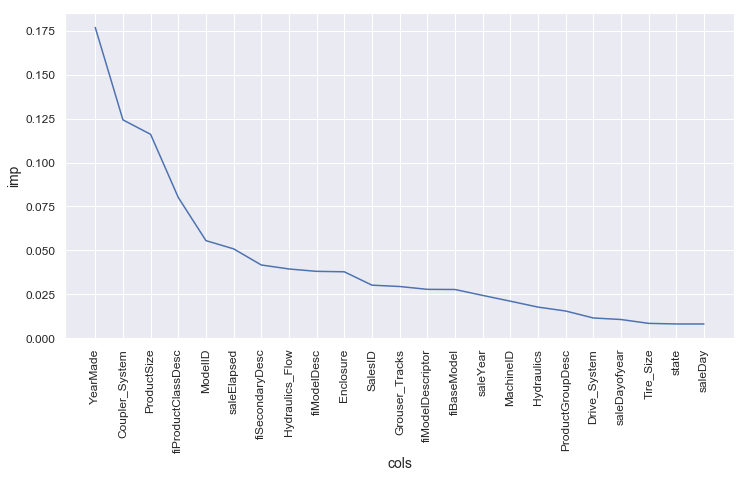

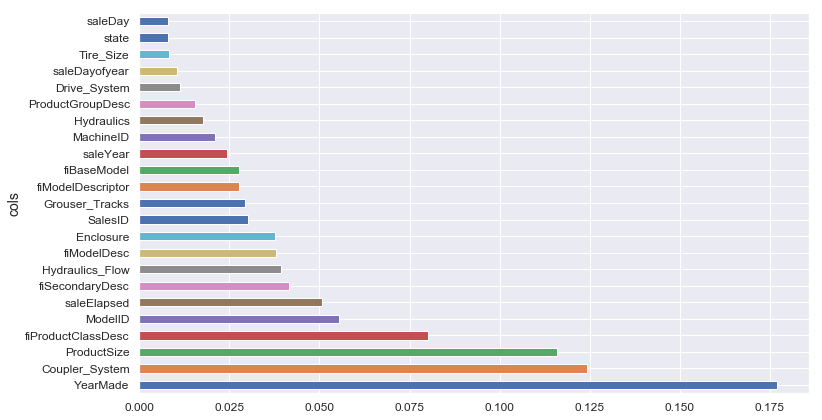

In [36]:
# let's look at the new feature importance
fi = rf_feat_importance(m, df_keep)
plot_feat_importance(fi);

## One-hot Encoding

process_dataframe's optional *max_n_cat* argument will turn some categorical variables into new columns.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [37]:
df_trn2, y_trn, nas = process_dataframe(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_val = split_vals(df_trn2, n_train)

In [38]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
train_regressor(m, X_train, y_train)
m_preds, r2, rmse = predict_and_evaluate_regressor(m, X_val, y_val)

  R2 (Training): 0.9100728675113297
RMSE (Training): 0.04302847152550097
      OOB Score: 0.8923702260347591
             R2: 0.88525
           RMSE: 0.25348


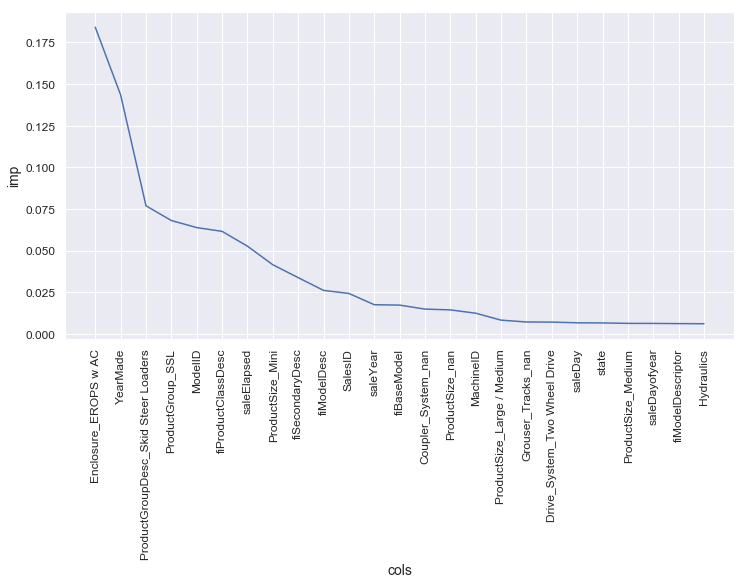

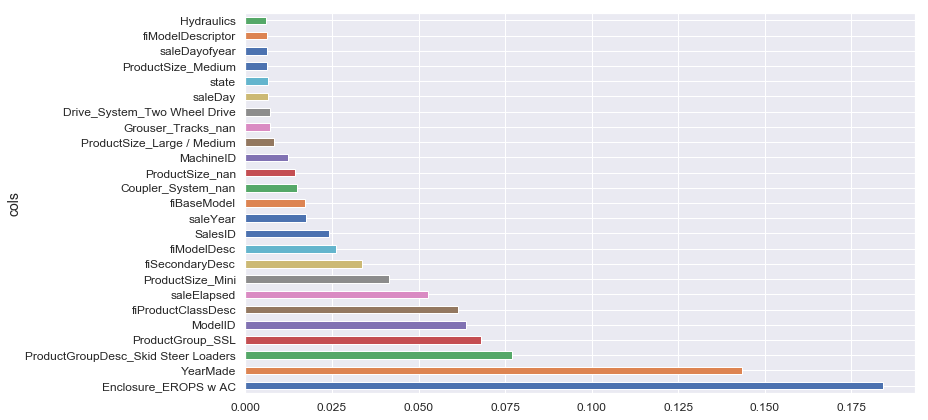

In [39]:
fi = rf_feat_importance(m, df_trn2)
plot_feat_importance(fi,top=25)

Interesting part here is, although results haven't improved much, the Enclosure feature that was mid-table in terms of feature importance, now actually shows that a specific value is the most important feature in the dataset. We probably need to take a look at what **Enclosure_EROPCS w AC** means

## Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

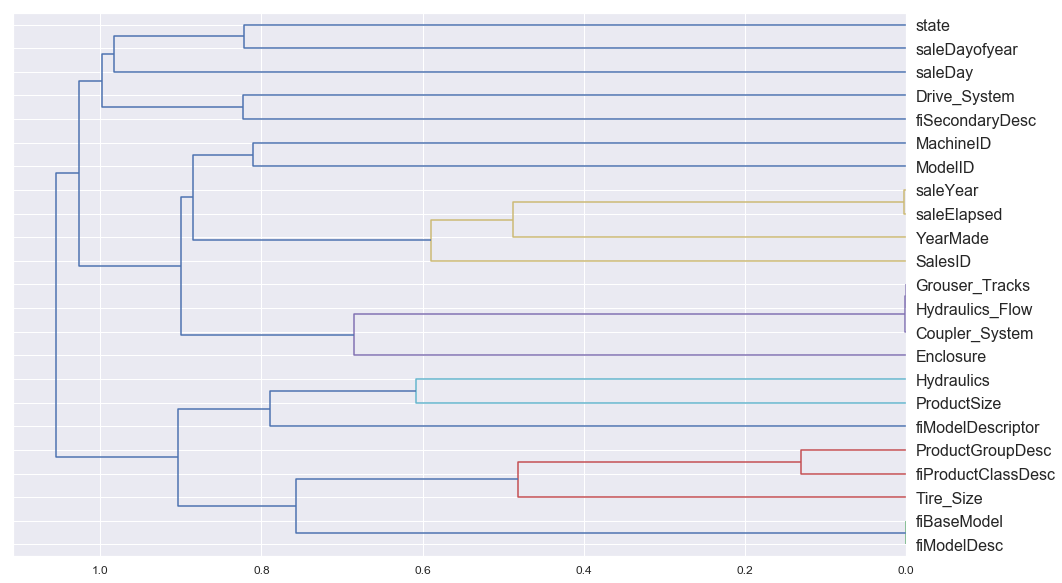

In [40]:
corr = analyze_redundant_features(df_keep)

Looking at this, we can identify clusters of features that seem to be very correlated. Looking to the right, we find groups that are close together. In this case, there are 4 group (from bottom to top):

- fiBaseModel and fiModelDesc
- ProductGroup and ProductGroupDesc
- Grouser_Tracks_ Hydraulics_Flow, Coupler_System
- saleYear, saleElapsed

In [41]:
# just to check the values of correlation within a group and outside of it (this is what the function above does)
inside_group = np.round(scipy.stats.spearmanr(df_keep[['Grouser_Tracks','Coupler_System']]).correlation, 4)
outside_group = np.round(scipy.stats.spearmanr(df_keep[['Grouser_Tracks','saleYear']]).correlation, 4)

print(f"inside: {inside_group}, outside: {outside_group}")

inside: 0.9981, outside: 0.0804


Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy. The **analyze_single_feature_removal_regression** function eliminated one feature at a time and measures the impact to the oob_score on a default RandomForestRegressor

In [44]:
# create new training set
x, _ = split_vals(df_keep, n_train)
f_list = ['saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System']
analyze_single_feature_removal(m, x, y_train, f_list, metric='oob')

Baseline - 0.8941644312685431
------------------------------
saleYear - 0.89441163156211 (0.00025)
saleElapsed - 0.8917819029572467 (-0.00238)
fiModelDesc - 0.8936593409894772 (-0.00051)
fiBaseModel - 0.8937845650943704 (-0.00038)
Grouser_Tracks - 0.895116689105009 (0.00095)
Coupler_System - 0.8950771124610073 (0.00091)


It looks like we can try one from each group for removal. Let's see what that does.

In [45]:
x, _ = split_vals(df_keep, n_train)
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
analyze_multiple_feature_removal(m, x, y_train, to_drop, metric='oob')

Baseline - 0.8943636382537202
------------------------------
Result - 0.8934200413379603 (-0.00094)


This looks really good! Results are very similar and we are simplifying our model.

Let's use this new dataframe. We'll save the list of columns so we can reuse it later.

In [46]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_val = split_vals(df_keep, n_train)

In [47]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [48]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

In [49]:
print(f"Total number of features: {len(df_keep.columns)}")

Total number of features: 20


Let's try it with the whole dataset now

In [50]:
reset_rf_samples()

In [51]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
train_regressor(m, X_train, y_train)
_ = predict_and_evaluate_regressor(m, X_val, y_val)

  R2 (Training): 0.9674098084785991
RMSE (Training): 0.015593804551322591
      OOB Score: 0.9089895476635986
             R2: 0.90864
           RMSE: 0.22618


### Summary

The steps so far are: 
- use **set_rf_samples** to a smaller number so we can analyze quickly
- use **process_dataframe** to prepare dataset
- create a simple RandomForest
- used **rf_feat_importance** to get most important features
- removed the features that were less important (< 0.005) and saved it into df_keep
- OneHotEncoding everything under 7 distinct values (didn't help from a results perspective so we didn't do it)
- Using df_keep (not one-hot encoded), ran **analyze_redundant_features** to find out clusters of similar features
- Removed one feature in each group and ended up with just 21 features in the model
- Used **reset_rf_samples** to test bootstrap model

## Partial dependence

In [52]:
# as we're doing analysis, let's speed it up
set_rf_samples(50000)

In [53]:
# this analysis is easier with one-hot encoded variables, so let's do that again
df_trn2, y_trn, nas = process_dataframe(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_val = split_vals(df_trn2, n_train)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
train_regressor(m, X_train, y_train)

  R2 (Training): 0.9099765349470176
RMSE (Training): 0.04307456487781594


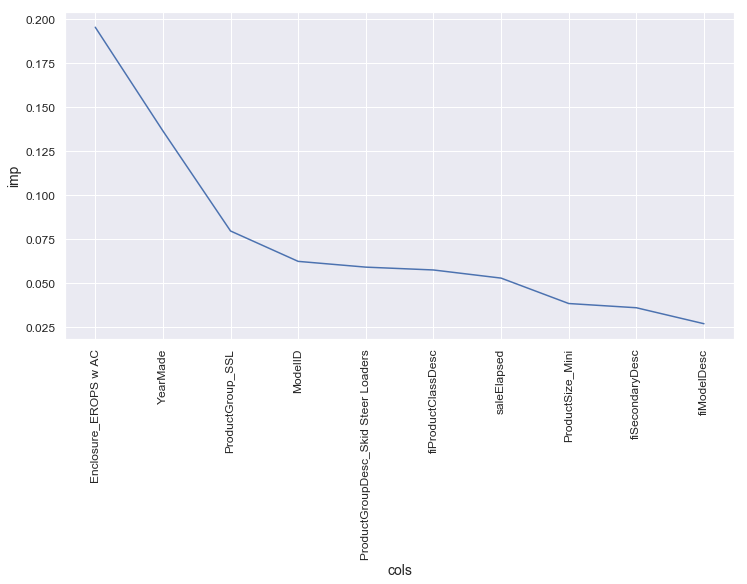

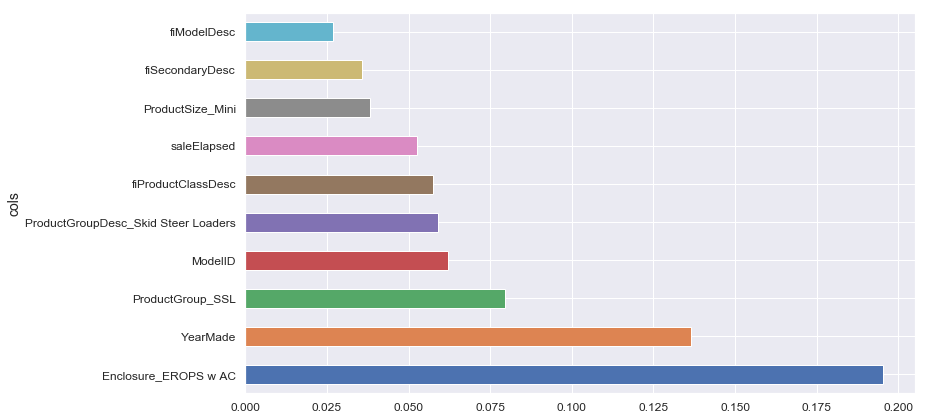

In [54]:
plot_feat_importance(rf_feat_importance(m, df_trn2)[:10])

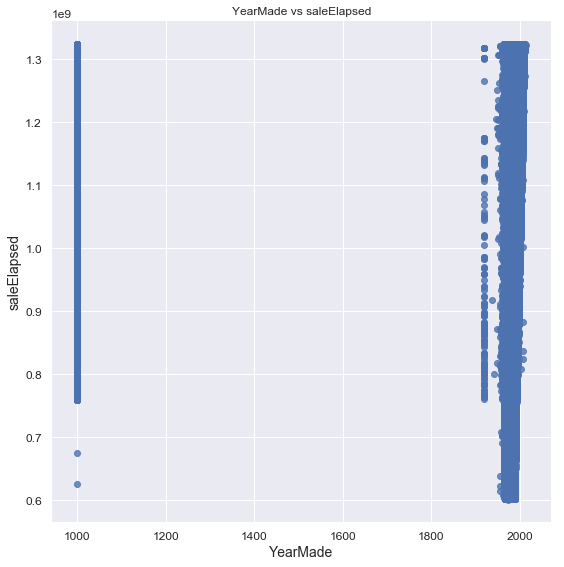

In [57]:
plot_scatter(df_raw, 'YearMade','saleElapsed', title='YearMade vs saleElapsed')

Obviously bulldozers were not done in the year 1000, which means this is a substitute for missing data of some sort

In [58]:
# let's remove those values and sample our dataset
x_all = get_sample(df_raw[df_raw.YearMade > 1930], 500)

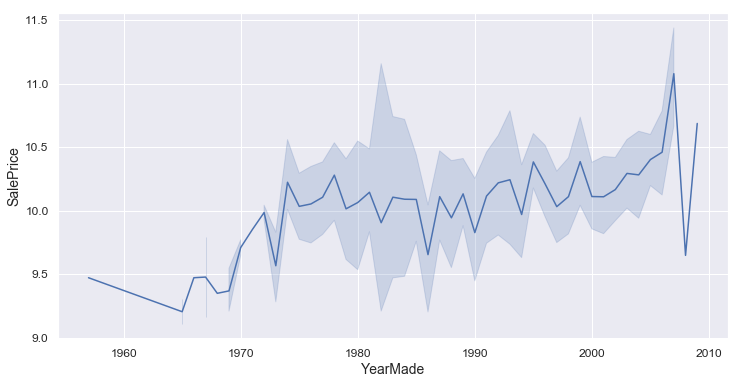

In [59]:
plot_line(x_all, 'YearMade', 'SalePrice')

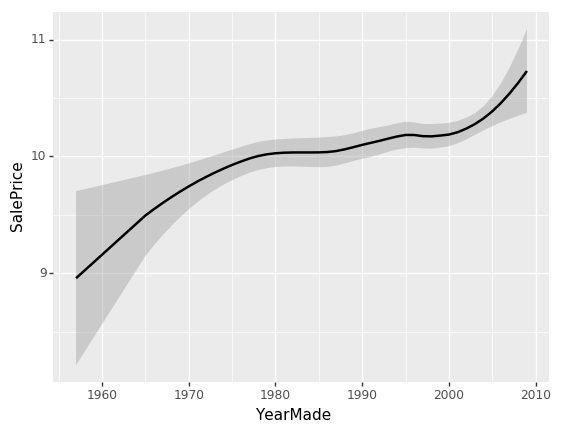

<ggplot: (8761359087848)>

In [60]:
# use ggplot to smooth the curve and get a more easy to comprehend graphic
from plotnine import *
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

This might indicate a weird aspect of YearMade. We would supposed that more recent vehicles would get a higher price. That dip we see between 1990 and 2000 is probably related to something else.

An interesting way of looking into this is to use a partial dependence plot. We use the trained model to run predictions along all the values of a particular variable (like YearMade), by forcing the same value across the entire dataset and averaging predictions. This allows us to see how the target variable evolves with our feature, all other things being equal (basically removing outside factors)

In [ ]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [ ]:
plot_partial_dependence(m, x, 'YearMade');

In [ ]:
plot_partial_dependence(m, x, 'YearMade', clusters=5);

By looking at this, we realize that in fact SalePrice keeps rising as YearMade evolves. As we are using log of price, this is almost a direct relationship.

So the process is: look at important features and look at them independently using a partial dependence plot. This is not necessarily actionable data, but it provides insights about the dataset. 

We can also look at interactions between two variables.

In [ ]:
# this is throwing an error with new matplotlib

#feats = ['saleElapsed', 'YearMade']
#p = pdp.pdp_interact(m, x, x.columns, feats)
#pdp.pdp_interact_plot(p, feats)

In [ ]:
plot_partial_dependence(m, x, ['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure');

Turns out this is the type of cabin.
OROPS is open cabin, the other two are closed with our without AC. That makes sense and we see how the price shifts in this category

In [ ]:
# based on some of this insights, let's make a couple of changes
# start by setting a more sensible low YearMade of 1950
df_raw.YearMade[df_raw.YearMade<1950] = 1950
# create age feature
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

In [ ]:
# let's evaluate this on the bootstrap model
reset_rf_samples()

X_train, X_val = split_vals(df_keep, n_train)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
train_regressor(m, X_train, y_train)
predict_and_evaluate_regressor(m, X_val, y_val)
plot_feat_importance(rf_feat_importance(m, df_keep));

Slight improvement with the **age** feature. Might be interesting to add it. Notice however how YearMade dropped significantly because age already encompasses some of that information.

## Tree interpreter

In [ ]:
from treeinterpreter import treeinterpreter as ti

In [ ]:
# take one specific pre-processed row
row = df_keep.values[None, 0]
row

In [ ]:
# create an unprocessed validation set with the same indexes, to print the actual category values instead of codes
_, df_valid = split_vals(df_raw[df_keep.columns], n_train)

In [ ]:
prediction, bias, contribution_sum = tree_interpret_prediction(m, df_valid, row)

In [ ]:
# prediction is the predicted value, bias is the average and contribution is how much it differs from each other
prediction, bias, contribution_sum

## Extrapolation

We still have a big difference between our training score and our validation score.
We should try and understand that difference. Usually it's related to temporal components. 

In [ ]:
# create a dataset with a column identifiying if a row is on the validation set or not
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_train] = 0
x, y, nas = process_dataframe(df_ext, 'is_valid')

In [ ]:
from mlutils.models.classification import *
# we create a classifier that tries to predict wether or not a row is in the validation set
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
train_classifier(m, x, y)

The fact that we get that score means the validation set is definetely not a random sample. In something like Kaggle, we can grab the test set, stack it with the training set and try to predict if is test or not. If we can, it's not a random sample.

In [ ]:
# get most important features
fi = rf_feat_importance(m, x); fi[:10]

In [ ]:
feats=['SalesID', 'saleElapsed', 'MachineID']
X_train, X_val = split_vals(df_keep, n_train)

In [ ]:
(X_train[feats]/1000).describe()

In [ ]:
(X_val[feats]/1000).describe()

SalesID is clearly an ID that is auto-incremented. We can see the distributions are quite different. 
So let's try to drop them as they might not make good predictors for our validation data

In [ ]:
x.drop(feats, axis=1, inplace=True)
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
train_classifier(m, x, y)

We still can predict it fairly accurately. Now that we dropped it, other features come to light.

In [ ]:
fi = rf_feat_importance(m, x); fi[:10]

In [ ]:
set_rf_samples(50000)
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [ ]:
# get a baseline
X_train, X_val = split_vals(df_keep, n_train)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
train_regressor(m, X_train, y_train)
preds, r2, rmse = predict_and_evaluate_regressor(m, X_val, y_val)

In [ ]:
# check the impact on Val R2 score by removing each feature (one at a time)
analyze_single_feature_removal_regression_r2(X_train, y_train, X_val, y_val, feats, n_estimators=40, min_samples_leaf=3, max_features=0.5)

In [ ]:
reset_rf_samples()

In [ ]:
to_drop = ['SalesID', 'MachineID', 'saleDayofyear'] # potentially age as well

In [ ]:
X_train, X_val = split_vals(df_keep, n_train)
analyze_multiple_feature_removal_regression_r2(X_train, y_train, X_val, y_val, to_drop, n_estimators=40, min_samples_leaf=3, max_features=0.5)

In [ ]:
# check to see if age should be dropped too
to_drop2 = to_drop.copy()
to_drop2.append('age')
analyze_multiple_feature_removal_regression_r2(X_train, y_train, X_val, y_val, to_drop2, n_estimators=40, min_samples_leaf=3, max_features=0.5)

So removing these 3 time dependent variables, we get a super high score

In [ ]:
# let's go ahead and test out model then
df_subs = df_keep.drop(to_drop, axis=1)
X_train, X_val = split_vals(df_subs, n_train)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
train_regressor(m, X_train, y_train)
predict_and_evaluate_regressor(m, X_val, y_val)

In [ ]:
plot_feat_importance(rf_feat_importance(m, X_train))

In [ ]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

## Our final model!

In [ ]:
%%time
m = RandomForestRegressor(n_estimators=200, max_features=0.5, n_jobs=-1, oob_score=True)
train_regressor(m, X_train, y_train)
predict_and_evaluate_regressor(m, X_val, y_val)

That would be enough to score us the first place!!!

### Recap

The steps taken:
- use **set_rf_samples** to a smaller number so we can analyze quickly
- use **process_dataframe** to prepare dataset
- create a simple RandomForest
- used **rf_feat_importance** to get most important features
- removed the features that were less important (< 0.005) and saved it into df_keep
- OneHotEncoding everything under 7 distinct values (didn't help from a results perspective so we didn't do it)
- Using df_keep (not one-hot encoded), ran **analyze_redundant_features** to find out clusters of similar features
- Removed one feature in each group and ended up with just 21 features in the model
- Used **reset_rf_samples** to test bootstrap model
- Added the age column based on the insights from dependant plots
- Through extrapolation, removed all time-sensitive variables **'SalesID', 'MachineID', 'saleDayofyear'** that were causing differences between train and validation data

### Note: we should train the model in with the full data now (train + validation) and predict against the test set